In [43]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import chi2
from impyute.imputation.cs import mice
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, Lipinski, Draw
from mordred import Calculator, descriptors
import joblib
from sklearn.model_selection import KFold

In [44]:
df=pd.read_csv("dopamine_receptor_total.csv")
df.head(5)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,34848,[],CHEMBL872503,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000221,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,17.0
1,NaN,34849,[],CHEMBL671773,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,224.0
2,NaN,53423,[],CHEMBL872503,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000221,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,33.0
3,NaN,53424,[],CHEMBL671773,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,314.0
4,NaN,53425,[],CHEMBL671771,Inhibitory activity against [3H]-Dopamine upta...,B,NaN,NaN,BAO_0000190,BAO_0000221,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,373.0


In [45]:
df.shape

(8227, 45)

In [46]:
for col in df.columns:
    print(col)

activity_comment
activity_id
activity_properties
assay_chembl_id
assay_description
assay_type
assay_variant_accession
assay_variant_mutation
bao_endpoint
bao_format
bao_label
canonical_smiles
data_validity_comment
data_validity_description
document_chembl_id
document_journal
document_year
ligand_efficiency
molecule_chembl_id
molecule_pref_name
parent_molecule_chembl_id
pchembl_value
potential_duplicate
qudt_units
record_id
relation
src_id
standard_flag
standard_relation
standard_text_value
standard_type
standard_units
standard_upper_value
standard_value
target_chembl_id
target_organism
target_pref_name
target_tax_id
text_value
toid
type
units
uo_units
upper_value
value


In [47]:
#Unique value counts in standard_type
df.standard_type.value_counts()

IC50                                                   3402
Ki                                                     3072
Inhibition                                             1258
Activity                                                186
Ratio                                                    76
pKD                                                      56
EC50                                                     53
Log 1/C                                                  50
Kd                                                       21
% Ctrl                                                   12
% Inhibition of Control Specific Binding (Mean n=2)       9
Displacement                                              6
IC5                                                       4
Ratio Ki                                                  4
pKi                                                       3
Efficacy                                                  2
Ratio IC50                              

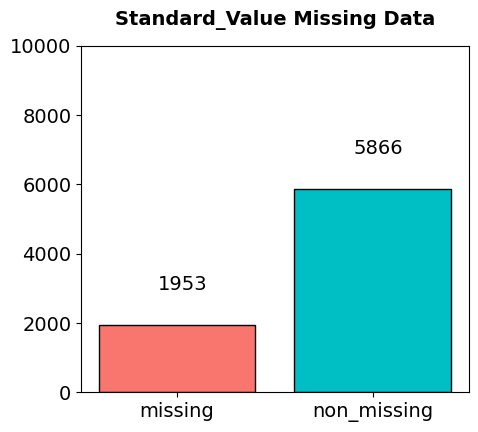

In [48]:
#MISSING DATA PLOT for all the activity classes
missing =data["standard_value"].isna().sum()
non_missing = data["standard_value"].notnull().sum()


x = ['missing', 'non_missing']
y = [missing, non_missing]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('Standard_Value Missing Data', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,10000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()


In [49]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.reset_option("all")

/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_95008/1671304794.py:3: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option("all")
/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_95008/1671304794.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option("all")
/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_95008/1671304794.py:3: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option("all")


In [50]:
#selecting only IC50, Ki, Inhibition and Activity - 4 standard_type classes

data= df[(df['standard_type']=="IC50") | (df['standard_type']=="Ki") | (df['standard_type']=="Inhibition") | (df['standard_type']=="Activity")]
data=data.reset_index(drop=True)
print(data.standard_type.value_counts())
print(data.shape)


IC50          3402
Ki            3072
Inhibition    1258
Activity       186
Name: standard_type, dtype: int64
(7918, 45)


In [51]:
data

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,34848,[],CHEMBL872503,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000221,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,17.00
1,NaN,34849,[],CHEMBL671773,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,224.00
2,NaN,53423,[],CHEMBL872503,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000221,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,33.00
3,NaN,53424,[],CHEMBL671773,Binding affinity towards dopamine transporter ...,B,NaN,NaN,BAO_0000192,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,314.00
4,NaN,53425,[],CHEMBL671771,Inhibitory activity against [3H]-Dopamine upta...,B,NaN,NaN,BAO_0000190,BAO_0000221,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,373.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7913,Not Active,23384612,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4880843,"Transporter, Dopamine (DAT) Eurofins-Panlabs r...",B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,% inhibition,%,UO_0000187,NaN,-12.00
7914,Not Active,23385781,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4880041,GPCRScan assay: inhibition of DAT,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,% Inhibition,%,UO_0000187,NaN,-17.37
7915,Not Active,23385847,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4880041,GPCRScan assay: inhibition of DAT,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,% Inhibition,%,UO_0000187,NaN,-18.05
7916,Not Active,23385962,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4888418,dopamine transporter (h) CEREP screen,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Dopamine transporter,9606,NaN,NaN,% inhibition,%,UO_0000187,NaN,30.00


In [52]:
data.isnull().sum()

activity_comment             5542
activity_id                     0
activity_properties             0
assay_chembl_id                 0
assay_description               0
assay_type                      0
assay_variant_accession      7903
assay_variant_mutation       7903
bao_endpoint                    0
bao_format                      0
bao_label                       0
canonical_smiles               99
data_validity_comment        7738
data_validity_description    7738
document_chembl_id              0
document_journal             2145
document_year                1742
ligand_efficiency            4272
molecule_chembl_id              0
molecule_pref_name           5574
parent_molecule_chembl_id       0
pchembl_value                4109
potential_duplicate             0
qudt_units                   1832
record_id                       0
relation                     2233
src_id                          0
standard_flag                   0
standard_relation            2233
standard_text_

In [53]:
#missing standard values
print("missing in standard_value",data.standard_value.isna().sum())
print("missing in canonical_smiles",data.canonical_smiles.isna().sum())

missing in standard_value 2017
missing in canonical_smiles 99


In [54]:
#Drop the rows with missing canonical smiles - 99 rows
data=data.dropna(subset = ['canonical_smiles'])
data=data.reset_index(drop=True)
print("missing in canonical_smiles",data.canonical_smiles.isna().sum())

missing in canonical_smiles 0


In [55]:
#Select the most important features from data
data = data[['molecule_chembl_id','canonical_smiles','standard_type','standard_value','standard_units']]

In [56]:
data.shape

(7819, 5)

In [ ]:
#Lepinski descriptors


In [58]:
#function for lipinski calculator from. : https://codeocean.com/explore/capsules?query=tag:data-curation
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
     
    
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol) #Molecular weight
        desc_HeavyAtomMolWt = Descriptors.HeavyAtomMolWt(mol) #molecular weight of the molecule ignoring hydrogens
        desc_MolLogP = Descriptors.MolLogP(mol) #LogP
        desc_MolMR = Descriptors.MolMR(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol) #Number of Hydrogen Donors
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol) #Number of Hydrogen Acceptors
        desc_NumAtoms= mol.GetNumAtoms() #Number of atoms
        desc_num_aromatic_rings = Descriptors.NumAromaticRings(mol)
        desc_tpsa = Descriptors.TPSA(mol)
        desc_num_rotatable_bonds = Lipinski.NumRotatableBonds(mol)
        
           
        row = np.array([desc_MolWt,desc_HeavyAtomMolWt,
                        desc_MolLogP,desc_MolMR,
                        desc_NumHDonors,
                        desc_NumHAcceptors,desc_NumAtoms,desc_num_aromatic_rings,
                        desc_tpsa,desc_num_rotatable_bonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","HeavyAtomMolWt","LogP","MolMR","NumHDonors","NumHAcceptors","NumAtoms","AR","TPSA","RB"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors


In [59]:
lipinski1 = lipinski(data.canonical_smiles)
lipinski1

,MW,HeavyAtomMolWt,LogP,MolMR,NumHDonors,NumHAcceptors,NumAtoms,AR,TPSA,RB
0,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0
1,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0
2,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0
3,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0
4,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0
...,...,...,...,...,...,...,...,...,...,...
7814,440.478,419.310,5.5581,125.1575,2.0,5.0,33.0,4.0,98.90,6.0
7815,574.025,546.809,4.7203,136.0895,1.0,8.0,38.0,3.0,105.90,7.0
7816,574.025,546.809,4.7203,136.0895,1.0,8.0,38.0,3.0,105.90,7.0
7817,581.116,547.852,6.1677,164.0938,1.0,6.0,42.0,5.0,80.48,7.0


In [60]:
lipinski1.shape

(7819, 10)

In [61]:
#Combining all to one dataframe
data_all=pd.concat([data,lipinski1], axis=1)

In [62]:
data_all

,molecule_chembl_id,canonical_smiles,standard_type,standard_value,standard_units,MW,HeavyAtomMolWt,LogP,MolMR,NumHDonors,NumHAcceptors,NumAtoms,AR,TPSA,RB
0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.00,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0
1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.00,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0
2,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,IC50,373.00,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0
3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.00,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0
4,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.00,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814,CHEMBL4802045,CC[C@@H](Nc1c(C#N)c(-c2ccc(-c3cccc(C)c3F)cc2)n...,Inhibition,-12.00,%,440.478,419.310,5.5581,125.1575,2.0,5.0,33.0,4.0,98.90,6.0
7815,CHEMBL4568735,CO[C@@H](C)c1c(Nc2ccc([C@H](N(C)C(=O)C3CCS(=O)...,Inhibition,-17.37,%,574.025,546.809,4.7203,136.0895,1.0,8.0,38.0,3.0,105.90,7.0
7816,CHEMBL4584981,CO[C@@H](C)c1c(Nc2ccc([C@@H](N(C)C(=O)C3CCS(=O...,Inhibition,-18.05,%,574.025,546.809,4.7203,136.0895,1.0,8.0,38.0,3.0,105.90,7.0
7817,CHEMBL4802042,COc1nc2ccc([C@@](O)(c3ccccc3)C3CCN(C(C)=O)CC3)...,Inhibition,30.00,%,581.116,547.852,6.1677,164.0938,1.0,6.0,42.0,5.0,80.48,7.0


In [63]:
data_all.shape

(7819, 15)

In [64]:
data_all.isna().sum()

molecule_chembl_id       0
canonical_smiles         0
standard_type            0
standard_value        1953
standard_units        1762
MW                       0
HeavyAtomMolWt           0
LogP                     0
MolMR                    0
NumHDonors               0
NumHAcceptors            0
NumAtoms                 0
AR                       0
TPSA                     0
RB                       0
dtype: int64

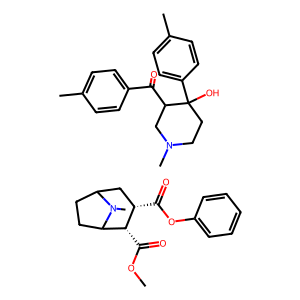

In [65]:
#Visualise each chemical compound

mol=Chem.MolFromSmiles(data_all["canonical_smiles"][7])
img = Draw.MolToImage(mol)
img

In [64]:
#Toxicty prediction using pre trained model

#https://github.com/pulimeng/eToxPred
def toxicity(smiles, verbose=False):
    model = joblib.load('etoxpred_best_model.joblib')
    mol = calc.pandas([smiles]).iloc[0]

    # Use the model to predict the toxicity of the compound
    toxicity_prediction = model.predict([mol])[0]

    # Return the probability of the compound being toxic
    return toxicity_prediction
    


In [65]:
#Convert the canonical smiles from string to rdkit molecular structure/molecular instance
data["mol"]=data["canonical_smiles"].apply(lambda x: Chem.MolFromSmiles(x))

data["mol"]

0       <rdkit.Chem.rdchem.Mol object at 0x28ba99770>
1       <rdkit.Chem.rdchem.Mol object at 0x28ba999a0>
2       <rdkit.Chem.rdchem.Mol object at 0x28ba99d90>
3       <rdkit.Chem.rdchem.Mol object at 0x28ba9a180>
4       <rdkit.Chem.rdchem.Mol object at 0x28ba9a260>
                            ...                      
7814    <rdkit.Chem.rdchem.Mol object at 0x28e1c9b60>
7815    <rdkit.Chem.rdchem.Mol object at 0x28e1c9bd0>
7816    <rdkit.Chem.rdchem.Mol object at 0x28e1c9c40>
7817    <rdkit.Chem.rdchem.Mol object at 0x28e1c9cb0>
7818    <rdkit.Chem.rdchem.Mol object at 0x28e1c9d20>
Name: mol, Length: 7819, dtype: object

In [17]:
smiles = ['CCOC(=O)C1=CC2=C(NC(=O)C=C2)C=C1', 'CC(=O)Nc1ccc(cc1)C(=O)O', np.nan]
smiles = smiles

In [ ]:
data["mol"].apply(toxicity)

In [ ]:
df["toxicity_prediction"]

In [66]:
#Separate out standard types
data_ki = data_all[data_all["standard_type"]=="Ki"]
data_ki=data_ki.reset_index(drop=True)
print("data_ki shape: ",data_ki.shape)
data_ic50 = data_all[data_all["standard_type"]=="IC50"]
data_ic50=data_ic50.reset_index(drop=True)
print("data_ic50 shape: ",data_ic50.shape)
data_inh = data_all[data_all["standard_type"]=="Inhibition"]
data_inh=data_inh.reset_index(drop=True)
print("data_inh shape: ",data_inh.shape)
data_act = data_all[data_all["standard_type"]=="Activity"]
data_act=data_act.reset_index(drop=True)
print("data_act shape: ",data_act.shape)

data_ki shape:  (3031, 15)
data_ic50 shape:  (3344, 15)
data_inh shape:  (1258, 15)
data_act shape:  (186, 15)


In [67]:
#Clean out all the standard_units
data_ki=data_ki[data_ki["standard_units"]=="nM"]
data_ki=data_ki.reset_index(drop=True)
print("data_ki shape: ",data_ki.shape)
data_ic50=data_ic50[data_ic50["standard_units"]=="nM"]
data_ic50=data_ic50.reset_index(drop=True)
print("data_ic50 shape: ",data_ic50.shape)
data_inh=data_inh[data_inh["standard_units"]=="%"]
data_inh=data_inh.reset_index(drop=True)
print("data_inh shape: ",data_inh.shape)
data_act=data_act[data_act["standard_units"]=="%"]
data_act=data_act.reset_index(drop=True)
print("data_act shape: ",data_act.shape)
#Ki and IC50 are in nanomolar units and inhibition and activity are in % units

data_ki shape:  (2193, 15)
data_ic50 shape:  (2466, 15)
data_inh shape:  (1258, 15)
data_act shape:  (128, 15)


In [68]:
#Print the standrad units
print("ki units: ",data_ki["standard_units"].value_counts())
print("ic50 units: ",data_ic50["standard_units"].value_counts())
print("inh units: ",data_inh["standard_units"].value_counts())
print("act units: ",data_act["standard_units"].value_counts())


ki units:  nM    2193
Name: standard_units, dtype: int64
ic50 units:  nM    2466
Name: standard_units, dtype: int64
inh units:  %    1258
Name: standard_units, dtype: int64
act units:  %    128
Name: standard_units, dtype: int64


In [69]:
#Missing values in each activity class
print("missing in ki",data_ki.standard_value.isna().sum())
print("missing in ic50",data_ic50.standard_value.isna().sum())
print("missing in inh",data_inh.standard_value.isna().sum())
print("missing in act",data_act.standard_value.isna().sum())

missing in ki 3
missing in ic50 13
missing in inh 175
missing in act 0


In [70]:
#Download data_inh to csv to try out all missing algorithms
data_inh.to_csv('missing_data.csv', index=False)

In [71]:
#Find missing rows
#data_ic50[data_ic50.standard_value.isna()] 

In [72]:
data_ki.isna().sum()

molecule_chembl_id    0
canonical_smiles      0
standard_type         0
standard_value        3
standard_units        0
MW                    0
HeavyAtomMolWt        0
LogP                  0
MolMR                 0
NumHDonors            0
NumHAcceptors         0
NumAtoms              0
AR                    0
TPSA                  0
RB                    0
dtype: int64

In [73]:
#Drop the small missing values for ki, ic50
data_ki = data_ki.drop(labels=[294,296,326], axis=0)
data_ki=data_ki.reset_index(drop=True)
data_ic50 = data_ic50.drop(labels=[17,18,27,28,167,185,194,294,322,330,333,335,343], axis=0)
data_ic50=data_ic50.reset_index(drop=True)

In [74]:
#Print range of data before imputing
print("Min inh value:",min(data_inh.standard_value),"Max inh value:",max(data_inh.standard_value))

Min inh value: -63.9 Max inh value: 105.0


<AxesSubplot: >

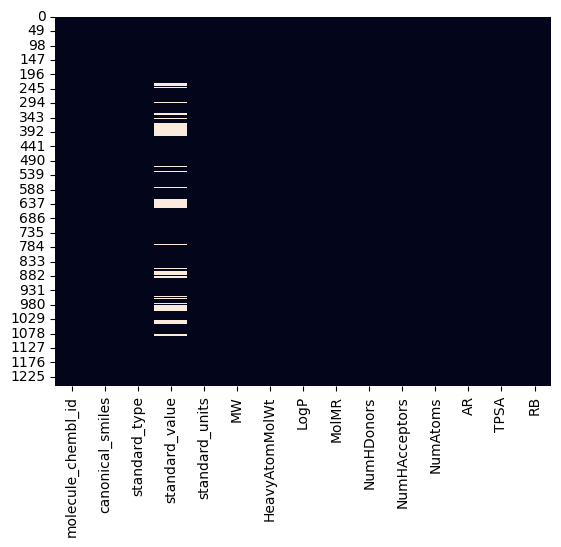

In [75]:
#Missing Data imputation

#Visualizing the missing valuees in data_inh
sns.heatmap(data_inh.isnull(), cbar=False)



<AxesSubplot: >

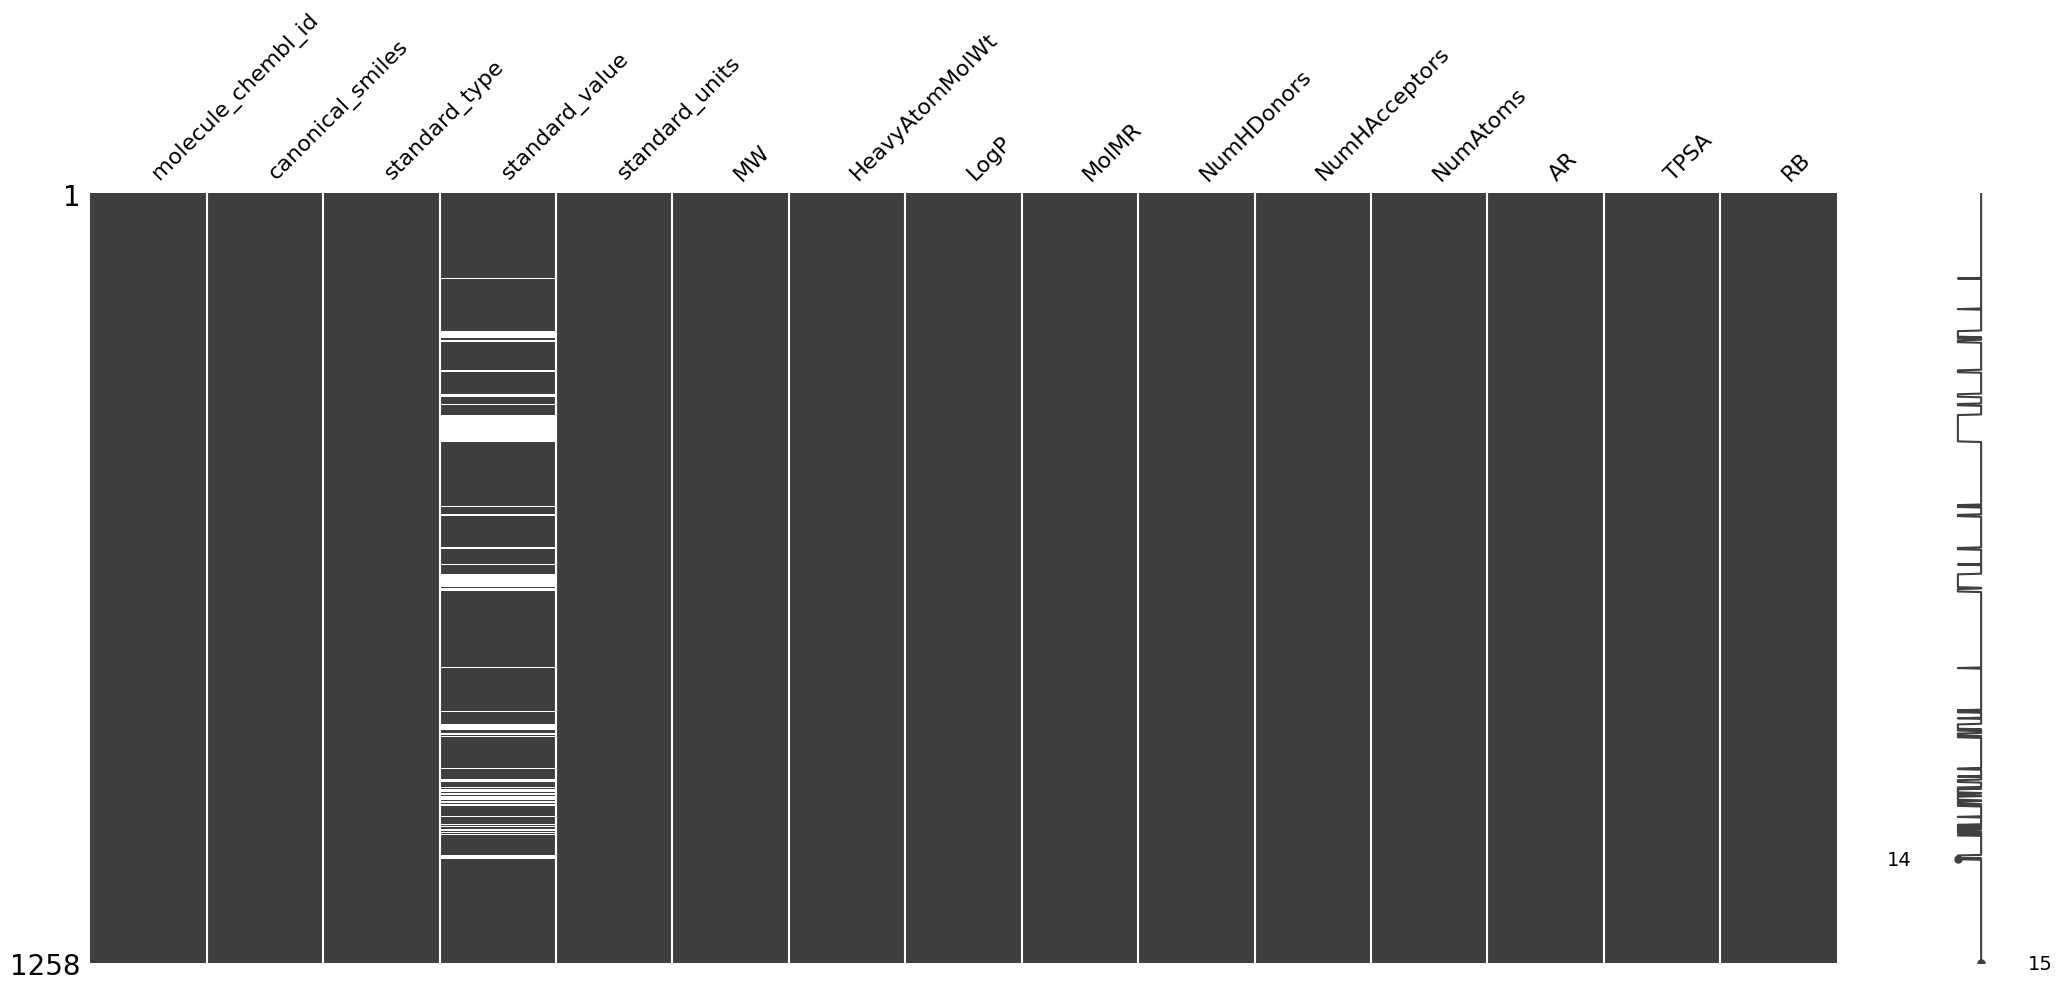

In [152]:
msno.matrix(data_inh)

In [76]:
#Null hypothesis - Missing values are MCAR
#Alternate hypthesis - Missing values are NOT MCAR

#Calculating chi-squared test statistic and p-value
chi2_stat = data_inh.isnull().sum().pipe(lambda x: ((x-x.mean())/x.std()).pow(2).sum())
p_val = chi2.sf(chi2_stat, data_inh.shape[1]-1)
if p_val < 0.05:
    print("The missing values are not MCAR")
else:
    print("The missing values are MCAR")
    

The missing values are MCAR


In [77]:
data_impute=data_inh[["standard_value","MW","HeavyAtomMolWt","LogP","MolMR","NumHDonors","NumHAcceptors","NumAtoms","AR","TPSA","RB"]]
data_impute.shape

(1258, 11)

In [78]:
max(data_inh["standard_value"])

105.0

In [79]:
#MICE ALGORITHM WITH K-FOLD CROSS VALIDATION
#Finding training and validation loss using MICE
mice_imputer=IterativeImputer()
n_folds = 5
#cross validation object
kf = KFold(n_splits=n_folds, shuffle=True)
#training error list
train_errors = np.zeros(n_folds)
#validation error list
val_errors = np.zeros(n_folds)

for i, (train_index, val_index) in enumerate(kf.split(data_inh)):
    # split data into training and validation sets
    train_df = data_impute.iloc[train_index]
    val_df = data_impute.iloc[val_index]

    # impute missing values using MICE on training set
    train_imputed_array = mice_imputer.fit_transform(train_df)
    train_imputed_df = pd.DataFrame(train_imputed_array, columns=train_df.columns)

    # calculate training error
    train_error = ((train_df - train_imputed_df) ** 2).mean().mean()
    train_errors[i] = train_error

    # impute missing values using MICE on validation set
    val_imputed_array = mice_imputer.transform(val_df)
    val_imputed_df = pd.DataFrame(val_imputed_array, columns=val_df.columns)

    # calculate validation error
    val_error = ((val_df - val_imputed_df) ** 2).mean().mean()
    val_errors[i] = val_error


print("Average training error:", train_errors.mean())
print("Average validation error:", val_errors.mean())

Average training error: 3814.246390869825
Average validation error: 3503.501749664158


In [80]:
#MICE ALGORITHM - working
mice_imputer=IterativeImputer()
imputed_array = mice_imputer.fit_transform(data_impute)
imputed_df = pd.DataFrame(imputed_array, columns=data_impute.columns)

In [81]:
print("missing in inh",imputed_df.standard_value.isna().sum())

missing in inh 0


In [82]:
#Concatenate standard values to data_inh

data_inh["standard_value"]=imputed_df["standard_value"]
data_inh.shape


(1258, 15)

In [400]:
#MIDAS ALGORITHM USING AUTOENCODERS - TRY MORE MISSING VALUES ALGORITHM FOR COMPARISON


In [411]:
#molecule_chembl_id - remove redundancy - ????
#data_all = data_all.drop_duplicates(['molecule_chembl_id'])
#data_all.molecule_chembl_id.value_counts()
#data_all.shape

In [83]:
#Checking range of values
#Ki is the binding affility of a compound to the dopamin receptor - strength of interaction
#Ki value represents the concentration of the ligand required to occupy 50% of the target protein binding sites. 
#Lowe Ki value indicates stronger binding affinity, higher Ki refers to weaker binding affinity
#Range: 0.12 to 912010839355911.6
print("Min Ki value:",min(data_ki.standard_value),"Max Ki value:",max(data_ki.standard_value))

#IC50 refers to the concentration of inhibitor required to reduce the enzymatic activity to half of the uninhibited 
#value. Lower the IC50, better the potency of the drug as we can use less concentration of this drug.
#Range: 0.002 to 744000
print("Min ic50 value:",min(data_ic50.standard_value),"Max ic50 value:",max(data_ic50.standard_value))

#Inhibition value indicates the compound's ability to bind to and block the activity of the target protein.
#Negative inhibition value indicates that, inversely it is stimulating the activity
#Higher the inhibition value, the better inhibition it provides
#Range: -63.9 to 105.0
print("Min inh value:",min(data_inh.standard_value),"Max inh value:",max(data_inh.standard_value))

#Activity is the quantitative endpoint of concentration of a compound required to achieve inhibition activity
#The higher the activity value, indicates a stronger biological activity
#Activity is from 0.0 to 10000
print("Min act value:",min(data_act.standard_value),"Max act value:",max(data_act.standard_value))

Min Ki value: 0.12 Max Ki value: 912010839355911.6
Min ic50 value: 0.002 Max ic50 value: 744000.0
Min inh value: -63.9 Max inh value: 105.0
Min act value: 0.0 Max act value: 10000.0


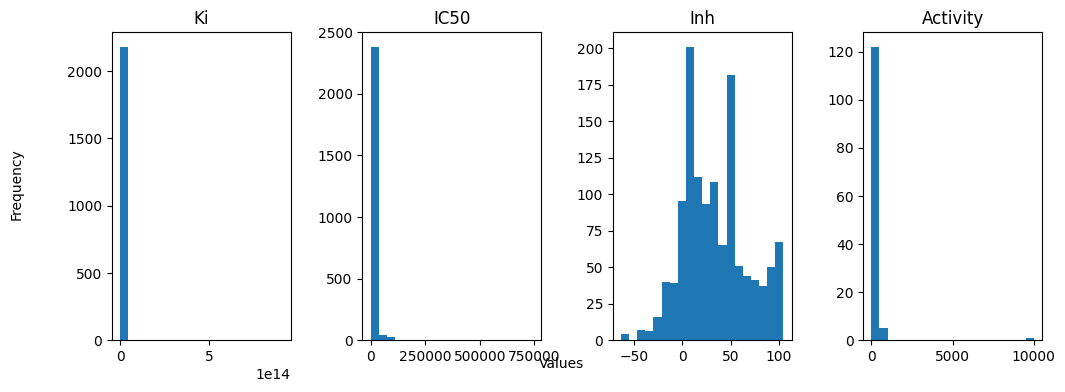

In [84]:
#Distribution of standard values in each class
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].hist(data_ki.standard_value, bins=20)
axs[1].hist(data_ic50.standard_value, bins=20)
axs[2].hist(data_inh.standard_value, bins=20)
axs[3].hist(data_act.standard_value, bins=20)

axs[0].set_title('Ki')
axs[1].set_title('IC50')
axs[2].set_title('Inh')
axs[3].set_title('Activity')

fig.text(0.5, 0.04, 'Values', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.4)

plt.show()

In [85]:
#Centering the inhibition values
#Adding 100 to the whole column
data_inh["standard_value"] =data_inh["standard_value"]+100
print("Min inh value:",min(data_inh.standard_value),"Max inh value:",max(data_inh.standard_value))

Min inh value: 36.1 Max inh value: 205.0


(array([  4.,   0.,   7.,   6.,  16.,  40.,  39.,  94., 202., 112.,  93.,
        108.,  65., 182.,  51.,  44.,  41.,  37.,  50.,  67.]),
 array([ 36.1  ,  44.545,  52.99 ,  61.435,  69.88 ,  78.325,  86.77 ,
         95.215, 103.66 , 112.105, 120.55 , 128.995, 137.44 , 145.885,
        154.33 , 162.775, 171.22 , 179.665, 188.11 , 196.555, 205.   ]),
 <BarContainer object of 20 artists>)

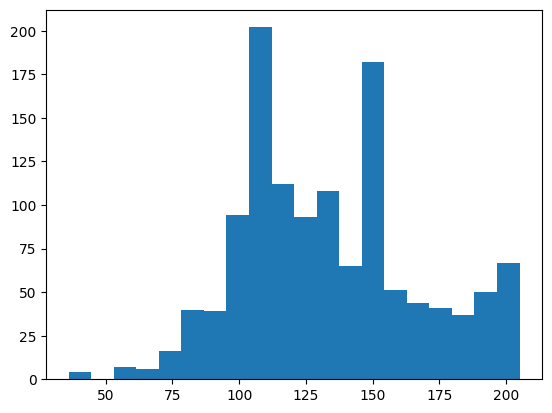

In [86]:
plt.hist(data_inh.standard_value, bins=20)

In [87]:
#SET THRESHOLDS FOR EACH CLASS AND CREATE COLUMN AS ACTIVE OR INACTIVE
#Ki
bioactivity_class = []
for i in data_ki.standard_value:
  if float(i) >= 100:
    bioactivity_class.append("inactive")
  elif float(i) <= 100:
    bioactivity_class.append("active")

bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
data_ki = pd.concat([data_ki, bioactivity_class], axis=1)

print(data_ki["bioactivity_class"].value_counts())
print(data_ki.shape)

inactive    1447
active       743
Name: bioactivity_class, dtype: int64
(2190, 16)


In [88]:
#IC50
bioactivity_class = []
for i in data_ic50.standard_value:
  if float(i) >= 100:
    bioactivity_class.append("inactive")
  elif float(i) <= 100:
    bioactivity_class.append("active")

bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
data_ic50 = pd.concat([data_ic50, bioactivity_class], axis=1)
print(data_ic50["bioactivity_class"].value_counts())
print(data_ic50.shape)

inactive    1751
active       702
Name: bioactivity_class, dtype: int64
(2453, 16)


In [89]:
#Inhibition
bioactivity_class = []
for i in data_inh.standard_value:
  if float(i) < 170:
    bioactivity_class.append("inactive")
  elif float(i) >= 170:
    bioactivity_class.append("active")

bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
data_inh = pd.concat([data_inh, bioactivity_class], axis=1)
print(data_inh["bioactivity_class"].value_counts())
print(data_inh.shape)

inactive    1053
active       205
Name: bioactivity_class, dtype: int64
(1258, 16)


In [90]:
#Activity
bioactivity_class = []
for i in data_act.standard_value:
  if float(i) < 100:
    bioactivity_class.append("inactive")
  elif float(i) >= 100:
    bioactivity_class.append("active")

bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
data_act = pd.concat([data_act, bioactivity_class], axis=1)
print(data_act["bioactivity_class"].value_counts())
print(data_act.shape)

inactive    95
active      33
Name: bioactivity_class, dtype: int64
(128, 16)


In [91]:
#CONCATENATE ALL THE 4 DATA CLASSES
data_all = pd.concat([data_ki,data_ic50,data_inh,data_act],ignore_index = True,sort = False)

data_all.shape

(6029, 16)

In [92]:
data_all.isna().sum()

molecule_chembl_id    0
canonical_smiles      0
standard_type         0
standard_value        0
standard_units        0
MW                    0
HeavyAtomMolWt        0
LogP                  0
MolMR                 0
NumHDonors            0
NumHAcceptors         0
NumAtoms              0
AR                    0
TPSA                  0
RB                    0
bioactivity_class     0
dtype: int64

In [455]:
data_all.to_csv("clean_data.csv")

In [127]:
#FINGERPRINTS

def generate_fingerprint(smiles):

    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    fingerprint = list(fingerprint.ToBitString())
    return fingerprint



In [142]:

fingerprint = df_combined["canonical_smiles"].apply(generate_fingerprint)
fingerprint

2       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
13      [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
                              ...                        
7495    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
7496    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7502    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7842    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7844    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: canonical_smiles, Length: 6045, dtype: object

In [96]:
#STATISTICAL TESTING FOR PARAMETRIC, NON PARAMETRIC - MANN WHITNEY U TEST
def mannwhitney(descriptor, verbose=False):
  #source: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = data_all[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = data_all[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [97]:
mannwhitney('standard_value')

,Descriptor,Statistics,p,alpha,Interpretation
0,standard_value,453406.0,0.0,0.05,Different distribution (reject H0)
